In [1]:
import numpy as np
import matplotlib.pyplot as plt

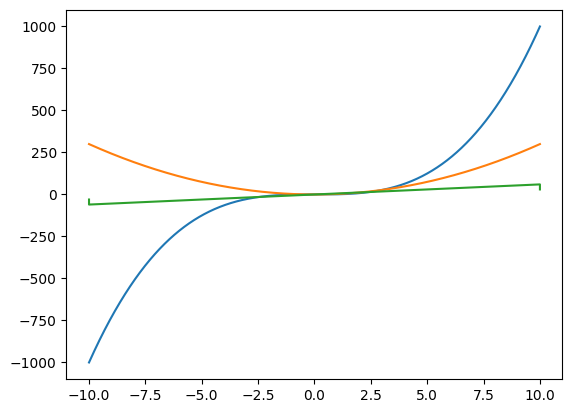

In [26]:
x = np.linspace(-10, 10, 1000000)
y = x**3
dx = x[1] - x[0]
plt.plot(x, y)
dy1 = np.gradient(y, x)
plt.plot(x, dy1 , label='1st Derivative')
dy2 = np.gradient(dy1, x)
plt.plot(x, dy2, label='2nd Derivative')

In [13]:
def derivative(x, y, order=1):
    if order == 1:
        dx = x[1] - x[0]
        dy = np.gradient(y, dx)
        return dy 
    
    else:
        return derivative(x, derivative(x, y, order=order-1), order=1)


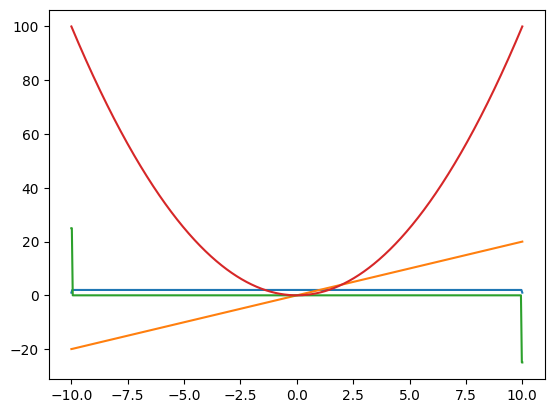

In [14]:
plt.plot(x, derivative(x, y, order=2), label='2nd Derivative')
plt.plot(x, derivative(x, y, order=1), label='1st Derivative')
plt.plot(x, derivative(x, y, order=3), label='3rd Derivative')
plt.plot(x, y, label='Original Function')

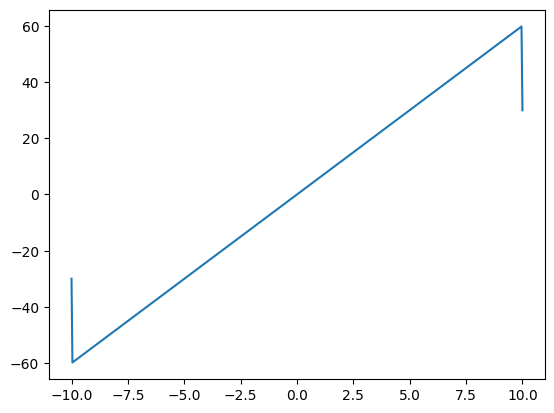

In [9]:
plt.plot(x, derivative(x, y, order=2), label='1st Derivative')

In [ ]:

class data2DPolynomialFitting:

    @staticmethod
    def fit(x, y, degree=2):
        coeffs = np.polyfit(x, y, degree)
        return np.poly1d(coeffs), coeffs

In [26]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
class Poly:
    degree = 2
    maxfev = 1000

    @classmethod
    def get_params(cls):
        return {
            "degree": cls.degree,
            "maxfev": cls.maxfev
        }

    @classmethod
    def set_params(cls, **kwargs):
        for key, value in kwargs.items():
            if key in cls.__dict__:
                setattr(cls, key, value)

    @classmethod
    def give_estimate(cls, x, y):
        guess = [np.median(x)]
        for i in range(cls.degree + 1):
            guess.append(0)
        return guess

    @classmethod
    def fit(cls, x, y):
        popt, pcov = curve_fit(cls.poly_func, x, y, p0=cls.give_estimate(x, y))

        return popt, cls.poly_func, pcov
    
    @staticmethod
    def poly_func(x, *params):
        return sum(p * (x-params[0])**i for i, p in enumerate(params[1:]))

    @classmethod
    def name_parameters(cls):
        params = {
            0 : "b"
        }
        for i in range(1, cls.degree + 1):
            params[i] = f"a_{i}"

        return params


In [19]:
Poly.name_parameters()

{0: 'b', 1: 'a_1', 2: 'a_2'}

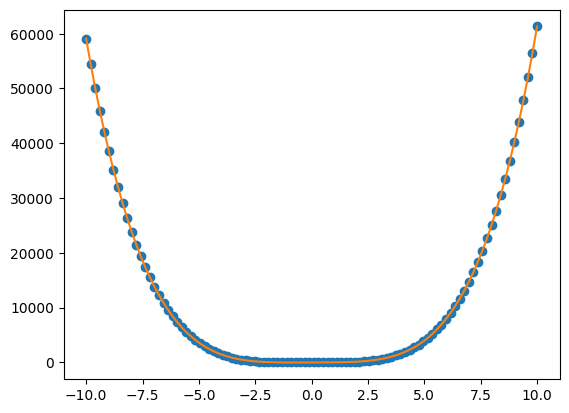

In [36]:
x = np.linspace(-10, 10, 100)
y = Poly.poly_func(x, *[0, 0, 12, 2, 1, 6]) + np.random.normal(0, 0.5, size=x.shape)

plt.plot(x, y, 'o', label='Data')

Poly.degree = 4
popt, model, pcov = Poly.fit(x, y)

plt.plot(x, model(x, *popt), label='Fitted Model')

In [37]:
class Exponential:
    '''
    Example of a fitting class and the methods involved.
    '''
    name = "exponential"
    maxfev = 1000

    @classmethod
    def get_params(cls):
        return {
            "maxfev": cls.maxfev
        }

    @classmethod
    def set_params(cls, **kwargs):
        for key, value in kwargs.items():
            if key in cls.__dict__:
                setattr(cls, key, value)

    @classmethod
    def give_estimate(cls, x, y):
        offset = y[-1]
        a = (y[0] - offset)

        k = (y[1] - y[0]) / (x[1] - x[0])

        x0 = - a / k

        return [a, x0, offset]

    @classmethod
    def fit(cls, x, y):
        popt, pcov = curve_fit(cls.exp_func, x, y, p0=cls.give_estimate(x, y))
        return popt, cls.exp_func, pcov

    @staticmethod
    def exp_func(x, a, x0, offset):
        return a * np.exp(- x / x0) + offset

    @classmethod
    def name_parameters(cls):
        return {
            0: "amplitude",
            1: "decay",
            2: "offset"
        }


In [40]:
popt

array([1.9371332 , 2.83203952, 0.55258307])

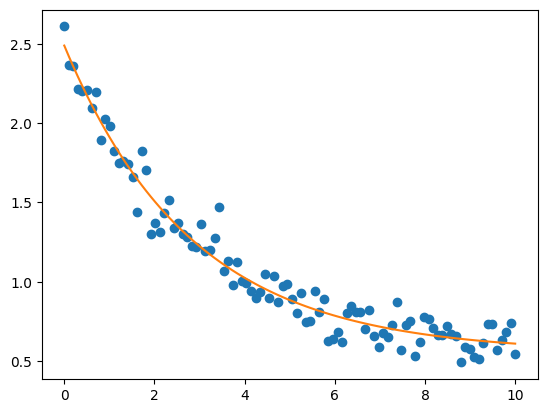

In [39]:
x = np.linspace(0, 10, 100)
y = 2 * np.exp(-x / 3) + np.random.normal(0, 0.1, size=x.shape) + 0.5

plt.plot(x, y, 'o', label='Data')

popt, model, pcov = Exponential.fit(x, y)

plt.plot(x, model(x, *popt), label='Fitted Model')


In [87]:
from scipy.signal import find_peaks

class Cosine:
    '''
    Example of a fitting class and the methods involved.
    '''
    name = "sinusoidal"
    beating = False
    maxfev = 1000

    @classmethod
    def get_params(cls):
        return {
            "maxfev": cls.maxfev
        }

    @classmethod
    def set_params(cls, **kwargs):
        for key, value in kwargs.items():
            if key in cls.__dict__:
                setattr(cls, key, value)

    @classmethod
    def give_estimate(cls, x, y):
        offset = (np.max(y) + np.min(y)) / 2
        
        freqs = np.fft.fftfreq(x.size, d=(x[1] - x[0]))
        fft_values = np.fft.fft(y - offset)

        indices = np.argsort(freqs)

        freqs = freqs[indices]
        fft_values = fft_values[indices]

        positive_indices = np.where(freqs > 0)[0]
        freqs = freqs[positive_indices]
        fft_values = fft_values[positive_indices]

        if cls.beating:
            peaks, _ = find_peaks(fft_values, height=0)
            guess_freqs = freqs[peaks]  
            guess_phases = np.angle(fft_values[peaks])
            guess_amps = np.abs(fft_values[peaks])
        
        else:
            index = np.argmax(np.abs(fft_values))
            guess_freqs = np.abs(freqs[index])
            guess_phases = np.angle(fft_values[index])
            guess_amps = (np.max(y) - np.min(y)) / 2

        # plt.plot(freqs, np.abs(fft_values))
        print(guess_amps, guess_freqs, guess_phases, offset)

        return guess_amps, guess_freqs, guess_phases, offset

    @classmethod
    def fit(cls, x, y):
        popt, pcov = curve_fit(cls.cos_func, x, y, p0=cls.give_estimate(x, y))
        return popt, cls.cos_func, pcov

    @classmethod
    def cos_func(cls, x, a, f, phase, offset):
        if cls.beating:
            y = 0
            for i in range(a.shape[0]):
                y += a[i] * np.sin(2 * np.pi * f[i] * x  + phase[i])
            
            return y + offset
        else:
            return a * np.cos(2 * np.pi * f * x - phase) + offset

    @classmethod
    def name_parameters(cls):
        return {
            0: "amplitude",
            1: "period",
            2: "phase",
            3: "offset"
        }


In [88]:
Cosine.fit(x, y)

1.2078581769588776 0.1484999999999997 1.6501516431109047 0.008778820948390664


(array([1.02508709, 0.15921086, 1.58251674, 0.0067202 ]),
 <bound method Cosine.cos_func of <class '__main__.Cosine'>>,
 array([[ 2.30035944e-04,  7.45192799e-08, -2.26910937e-07,
         -1.57549759e-07],
        [ 7.45192799e-08,  1.35067357e-07, -7.77276717e-10,
         -7.31193906e-09],
        [-2.26910937e-07, -7.77276717e-10,  2.00027682e-04,
         -1.27769218e-05],
        [-1.57549759e-07, -7.31193906e-09, -1.27769218e-05,
          1.10213455e-04]]))

1.1858781626714792 0.1484999999999997 1.679494416770528 0.026207942691824027
1.1858781626714792 0.1484999999999997 1.679494416770528 0.026207942691824027


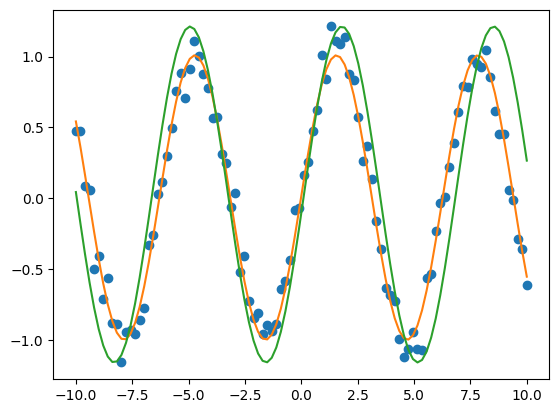

In [89]:
x = np.linspace(-10, 10, 100)
y = np.sin(x) + np.random.normal(0, 0.1, x.size)

plt.plot(x, y, 'o', label='Data')

popt, model, pcov = Cosine.fit(x, y)
plt.plot(x, model(x, *popt), label='Fitted Model')


plt.plot(x, Cosine.cos_func(x, *Cosine.give_estimate(x, y)), label='Initial Guess')

In [59]:
popt

array([-1.00725269,  0.15918681, -3.14327237,  0.00361362])

In [60]:
0.1587893*2*np.pi

0.9977025966973314